<a href="https://colab.research.google.com/github/spencerklawans/466-Project/blob/main/WildfirePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfire Prediction
By Spencer Klawans, Garrett Lew, and Will Fuchs

Github: https://github.com/spencerklawans/466-Project

#Introduction
The damage caused by wildfires is a current and pressing problem. Although wildfires are an important part of California’s ecosystem, the megafires of recent years are not. Megafires are detrimental both to California’s ecology, and its human residents. Megafires are attributed in part to California’s historic policy of complete wildfire suppression, which has allowed fuels to build up to dangerous levels. In addition, a warming climate and sustained drought conditions increase the likelihood of wildfires of any size. California cannot, and should not, attempt to prevent all wildfires, but what if the state could focus on preventing just the megafires? This report discusses a classifier, using Google Earth Engine, that can predict the severity of these wildfires. Using data about previous fires and what the area was like right before the fire, a model was trained to predict whether or not a fire would become a megafire. Specifically, a random forest model was trained on features such as vegetation coverage, wind speed, and temperature.
This report also discusses the knowledge discovered from the data and the classifier, such as which features are important for predicting fire severity.


#Background and Terms
Google Earth Engine was used to run all of the computation for this project. Here are some Google EE terms that are used throughout this report.
Image - A raster of data over space. Each pixel represents a physical location on the Earth’s surface. Each pixel has numeric data associated with it. For example, the surface temperature of California on a given day would be stored in an Image.
ImageCollection - A collection of Images, usually temporally distributed. For example, temperature data collected every day would be stored in an ImageCollection.
Feature - A vector defined by lat/lon points, often with associated data. For example, the perimeters of wildfires with start date could be stored in a Feature.
FeatureCollection - A collection of Features, with additional metadata. For example, all of the fires in California in the past 15 years could be stored in a FeatureCollection.


#Dataset Definitions
PRS - Percent Replacement Severity. The amount of replacement-severity fires relative to low- and mixed-severity fires under the presumed historical fire regime, and is defined as greater than 75 percent average top-kill within a typical fire perimeter for a given vegetation type
EVT - Existing vegetation type, represents the current distribution of the terrestrial ecological systems classification, developed by NatureServe for the western hemisphere, through 2016
EVC - Existing vegetation coverage, represents the vertically projected percent cover of the live canopy layer for a 30-m cell
EVH - Existing vegetation height, represents the average height of the dominant vegetation for a 30-m cell
ERA5 Daily - ERA5 DAILY provides aggregated values for each day for seven ERA5 climate reanalysis parameters: 2m air temperature, 2m dew point temperature, total precipitation, mean sea level pressure, surface pressure, 10m u-component of wind and 10m v-component of wind. Additionally, daily minimum and maximum air temperature at 2m has been calculated based on the hourly 2m air temperature data. Daily total precipitation values are given as daily sums. All other parameters are provided as daily averages.


#Methods
###Data selection
Google Earth Engine Image datasets were examined and selected based on their perceived relevance to wildfire in California. Data were considered relevant if they dealt with environmental factors in California during our selected time range. The datasets were composited into a dataset that contains the selected features mapped onto sampled pixels of previous fires. Care was taken to ensure that temporal data is sampled from up to 5 days before the fire started. Points with no data available within 5 days of the start of the fire were discarded.

###Model Selection
Initial models trialled include naive Bayes, random forest, and gradient boosted tree. Gradient boosting and naive Bayes each performed poorly, averaging close to 50% accuracy. With only two classes, this is equivalent to randomly guessing. The untuned random forest averaged 64% accuracy with low amounts of false positives.

###Model Training
The random forest train dataset consisted of sampling 200 data points from a set of fires that contained equal amounts of massive and non-massive fires. The test dataset consisted of sampling fifty data points from a separate set of fires that contained equal amounts of massive and non-massive fires.
Initially, both train and test datasets sampled points from the same set of massive and non-massive fires which led the classifiers to overfit the data. So the test and train sets were segregated into two sets of different non-overlapping fires. The training set consisted of seven massive fires and seven non-massive fires. The test set consisted of a completely different set of three massive and three non-massive fires.
Therefore the train and test datasets were split 70-30.

###Model Tuning
The random forest classifier was tuned by building a series of classifiers with different parameters. First, the number of trees was changed. Sizes tested were 10, 50, 100, 150, and 300. The results were graphed, and a forest size of 100 was selected. Then, the maximum depth of the trees were restricted to reduce overfitting. A depth of 3 was determined to be optimal. The forest size to accuracy calculations were then re-run with this maximum depth to ensure that 100 was still the optimal size. 


In [1]:
# Import libraries.
import ee
import folium

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=6stuhDhWkXzy3OeNnABGcg3wlEfkouqJi3fPuP2Atz8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4lGsRT4I8-nDMyE1MxpppoAwbQb86wRLwg1e60xQ-cB4F4Mih_ZuA

Successfully saved authorization token.


In [2]:
#Init KDD libraries

%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import time
import matplotlib.pyplot as plt

In [3]:
California = ee.Geometry.Rectangle(-124.18, 41.39, -114.35, 32.75)
earliestDataStart = '2014-09-01T00:00:00'
# Import our fire events as features
modis_fires = ee.FeatureCollection('JRC/GWIS/GlobFire/v2/FinalPerimeters').filterBounds(California).filter(ee.Filter.gte('InitialDate', ee.Date.millis(earliestDataStart)))
# filter for only fires with greater than 10,000,000 square meters
modis_fires = modis_fires.filter(ee.Filter.gt('area', 10000000)).randomColumn(seed=0)

# Add a band for if this is a really big fire or not. 
# NOTE: We are using fire size as a proxy for severity
massive_fire_threshold = 100000000
massive_fires = modis_fires.filter(ee.Filter.gt('area', massive_fire_threshold)).limit(10, 'random').map(lambda f: f.set({'massive': 1}))  # 158 fires
other_fires = modis_fires.filter(ee.Filter.lte('area', massive_fire_threshold)).limit(10, 'random').map(lambda f: f.set({'massive': 0}))   # 609 fires

# split the fires into a test and training set
massive_fires_test = massive_fires.limit(3, 'random', False)
massive_fires_train = massive_fires.limit(7, 'random', True)
other_fires_test = other_fires.limit(3, 'random', False)
other_fires_train = other_fires.limit(7, 'random', True)

modis_fires_train = massive_fires_train.merge(other_fires_train)
modis_fires_test = massive_fires_test.merge(other_fires_test)
modis_fires = modis_fires_train.merge(modis_fires_test)

In [4]:
slo = ee.Geometry.Point([-120.4358, 35.3102])

# Import ImageCollections
landfire_prs = ee.Image("LANDFIRE/Fire/PRS/v1_2_0/CONUS")
landfire_evc = ee.Image("LANDFIRE/Vegetation/EVC/v1_4_0/CONUS")
landfire_evh = ee.Image("LANDFIRE/Vegetation/EVH/v1_4_0/CONUS")
landfire_evt = ee.Image("LANDFIRE/Vegetation/EVT/v1_4_0/CONUS")
daily_temp = ee.ImageCollection("ECMWF/ERA5/DAILY").filterDate(earliestDataStart, '2021-01-01')

fire_image2 = modis_fires.reduceToImage(
    properties = ['InitialDate'], 
    reducer = ee.Reducer.first()).rename('InitialDate')

composite = landfire_evc.addBands(landfire_prs).addBands(landfire_evh).addBands(landfire_evt).addBands(fire_image2)

In [5]:
bands = ['PRS', 'EVC','EVH','EVT','mean_temp', 'wind_speed']
# split the data into training and test sets
fire_image = ee.Image().byte().paint(modis_fires, 'massive').rename('massive')

fire_points_train = fire_image.addBands(ee.Image.pixelLonLat()).stratifiedSample(
                                                              numPoints=200,
                                                              classBand='massive',
                                                              scale=30,
                                                              region=modis_fires_train.geometry()).map(
                                                                  lambda f: f.setGeometry(ee.Geometry.Point([f.get('longitude'), f.get('latitude')])))
                                                              
fire_points_test = fire_image.addBands(ee.Image.pixelLonLat()).stratifiedSample(
                                                              numPoints=50,
                                                              classBand='massive',
                                                              scale=30,
                                                              region=modis_fires_test.geometry()).map(
                                                                  lambda f: f.setGeometry(ee.Geometry.Point([f.get('longitude'), f.get('latitude')])))

                                                              



data = composite.sampleRegions(fire_points_train, properties=['massive'], scale=30, geometries=True)
data_test = composite.sampleRegions(fire_points_test, properties=['massive'], scale=30, geometries=True)


def getTempForDate(feature):
  initial_date = feature.get('InitialDate')
  date_filter = ee.Filter.lte('system:time_start', initial_date)
  tempImage = daily_temp.filter(date_filter).limit(1, 'system:time_start', False).first()
  tempImageSample = tempImage.sample(feature.geometry()).first()
  u_wind = ee.Number(tempImageSample.get('u_component_of_wind_10m'))
  v_wind = ee.Number(tempImageSample.get('u_component_of_wind_10m'))
  return feature.set({
      "mean_temp": tempImageSample.get('mean_2m_air_temperature'),
      "wind_speed": (u_wind.pow(2).add(v_wind.pow(2))).sqrt(),
      "date_offset": ee.Number(initial_date).subtract(tempImage.get('system:time_start'))
      })


five_days_millis = 432000000
# Get most recent temp data within the past 5 days 
data = data.map(getTempForDate).filter(ee.Filter.lte('date_offset', five_days_millis))
data_test = data_test.map(getTempForDate).filter(ee.Filter.lte('date_offset', five_days_millis))

In [6]:
#Outdated method because the training/test used the same set of fires
n_train = 0.6
n_val = 0.5
temp = data.filter(ee.Filter.lt('random', 1-n_train))
training = data.filter(ee.Filter.gte('random', 1-n_train))
validation = temp.filter(ee.Filter.lt('random', (1-n_train)*n_val))
testing = temp.filter(ee.Filter.gte('random', (1-n_train)*n_val))

In [7]:
#small_points = composite.sampleRegions(other_fires, geometries=True)
classifier = ee.Classifier.smileRandomForest(100).train(features=data, classProperty='massive', inputProperties=bands)
pred = data_test.classify(classifier)

#Results
After training the random forest model, an accuracy of 84% was achieved. Upon closer inspection of the confusion matrix, of the incorrect guesses, most of them were false positives. When it comes to predicting fire severity, this is much more favorable than false negatives as falsely assuming a fire will get big is better than assuming it won’t.


In [8]:
accuracy = pred.errorMatrix('massive', 'classification')
print(accuracy.getInfo())


[[49, 1], [32, 18]]


In [9]:
accuracies = {}
importances = {}
for n_trees in [10, 50, 100, 150, 300]:
  classifier = ee.Classifier.smileRandomForest(n_trees, maxNodes=3).train(features=data, classProperty='massive', inputProperties=bands)
  pred = data_test.classify(classifier)
  # print(pred.errorMatrix('massive', 'classification').getInfo())
  # print(classifier.explain().getInfo())
  importances[n_trees] = classifier.explain().getInfo()['importance']
  accuracies[n_trees] = pred.errorMatrix('massive', 'classification').accuracy().getInfo()

importances

{10: {'EVC': 0,
  'EVH': 0.09820491352753963,
  'EVT': 0.10453234171346235,
  'PRS': 0.664665059763864,
  'mean_temp': 1.5001365185873166,
  'wind_speed': 0.8801275976310734},
 50: {'EVC': 0.05587848764210723,
  'EVH': 0.9399936492023097,
  'EVT': 0.12513388196701788,
  'PRS': 2.1408585108805354,
  'mean_temp': 5.910780642427078,
  'wind_speed': 6.405630570551798},
 100: {'EVC': 0.12796169914383232,
  'EVH': 1.3757149796679293,
  'EVT': 0.5070584180255019,
  'PRS': 4.246835885821979,
  'mean_temp': 12.591717258017155,
  'wind_speed': 12.972651105428907},
 150: {'EVC': 0.16455741194760914,
  'EVH': 2.5331906043307364,
  'EVT': 0.7390129482039207,
  'PRS': 6.037624149418604,
  'mean_temp': 18.215467953881802,
  'wind_speed': 18.402336127475486},
 300: {'EVC': 0.5396529702625095,
  'EVH': 4.648168359064384,
  'EVT': 1.1001874658941735,
  'PRS': 13.283792960623636,
  'mean_temp': 34.874384975778824,
  'wind_speed': 35.394789860995544}}

Text(0, 0.5, 'accuracy')

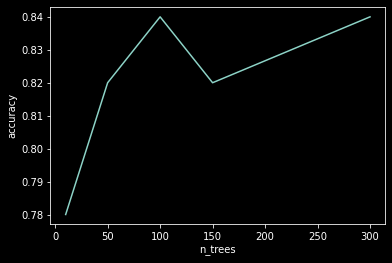

In [10]:
plt.style.use('dark_background')
plt.plot([x for x in accuracies.keys()], [x for x in accuracies.values()])
plt.xlabel('n_trees')
plt.ylabel('accuracy')


In [11]:
classifier = ee.Classifier.smileRandomForest(100, maxNodes=3).train(features=data, classProperty='massive', inputProperties=bands)
pred = data_test.classify(classifier)
pred.errorMatrix('massive', 'classification').getInfo()

[[47, 3], [13, 37]]

#KDD
After getting the results from the random forest model, importances were then looked into. It was found that the following were the most important to least important features: Wind speed, mean_temp, PRS, EVT, EVC, EVH. It's good to note that wind speed and temperature had relatively high importance scores compared to other attributes. This means that the largest predictor of wildfire severity is not directly in human control. It is possible that daily temperature is not a cause, but a proxy for a cause. It is likely that seasonal weather patterns are more important than daily information. Vegetation dryness increases during summer months, due in part to high winds and high temperatures. Daily temperature could be a proxy for month of the year, and the high importance of temperature could simply mean that wildfires are more likely to become megafires in summer.



In [12]:
# pred.errorMatrix('massive', 'classification').accuracy().getInfo()
classifier.explain().getInfo()['importance']

{'EVC': 0.12796169914383232,
 'EVH': 1.3757149796679293,
 'EVT': 0.5070584180255019,
 'PRS': 4.246835885821979,
 'mean_temp': 12.591717258017155,
 'wind_speed': 12.972651105428907}

# Vizualizing the results

In [ ]:
# Set visualization parameters. I'm pretty sure min and max should track to the min and max values of the set at https://developers.google.com/earth-engine/datasets/catalog/LANDFIRE_Fire_PRS_v1_2_0#bands
prs_viz_params = {
    'bands': ['PRS']
}

evc_vis_params = {
    'bands': ['EVC'],
    'opacity': 0.5
}
fires_viz_params = {
    'bands': ['massive'],
    'palette': ['#FF0000', '#0000FF'],
     'min': 0,
     'max': 1,
     'opacity': 0.5
}
pred_viz_params = {
    'palette': ['#FF0000', '#0000FF'],
    'min': 0,
    'max': 1,
    'opacity': 0.5
}

# Create a folium map object.
my_map = folium.Map(location=[35.3102, -120.4358], zoom_start=8)

# Add the fire severity & existing vegetation type images to the map object.
my_map.add_ee_layer(landfire_prs, prs_viz_params, 'Percent Replacement-Severity Fire')
my_map.add_ee_layer(landfire_evc, evc_vis_params, 'Existing Vegetation Cover')
my_map.add_ee_layer(fire_image, fires_viz_params, 'Fire Events')
my_map.add_ee_layer(ee.Image().paint(pred, 'classification'), pred_viz_params, 'Predicted Events')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

#Future Work
If more funding and time was provided for this project, a wildfire researcher would first be hired to verify the current findings and provide guidance on any features missed that could have a significant impact on the outcome of the final model. Secondly, due to time constraints from the free tier of Google Earth Engine, which can only run for 5 minutes, it would be beneficial to purchase more runtime and memory to train larger models. By doing this, more relevant features could be found that can actually be controlled, unlike wind speed and temperature. Promising features include average weather data for the weeks or months leading up to wildfire, yearly drought information, vegetation dryness, and  total mass of dead vegetation. The goal would be to uncover a relationship between weather data and vegetation dryness, which would be used to determine how quickly a given vegetation type will become combustible given drought conditions. Adding this to the dead vegetation gives a prediction of how much combustible fuel exists in a given area. This can be used to direct forest service resources to do controlled burns in problem areas, before they become problem areas. Lastly, expanding the training data to cover the entire US or world rather than just California could better generalize the model for a wider range of locations.
